USER_AGENT environment variable not set, consider setting it to identify your requests.


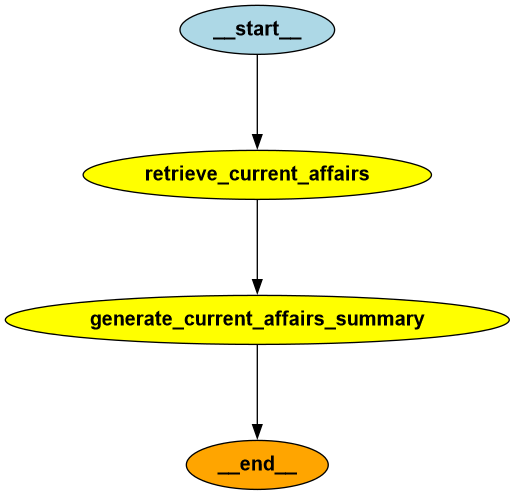

---RETRIEVE CURRENT AFFAIRS---
---GENERATE CURRENT AFFAIRS SUMMARY---

--- CURRENT AFFAIRS SUMMARY ---
1. Ukraine Conflict: The biggest drone strike hits Ukraine's second city, resulting in casualties.
2. Russia-Ukraine Tensions: Russia launches a large air attack following Ukraine's bomber raid.
3. Middle East: Israeli military retrieves the body of a Thai hostage in southern Gaza and attacks suburbs of Beirut.
4. Environmental Concerns: David Attenborough expresses dismay over the state of the ocean during a conversation with Prince William.
5. Trade Relations: Trump announces the end of his relationship with Elon Musk, while a call between Trump and Xi Jinping restores a trade truce.


In [1]:
from typing import List, TypedDict
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv()

"""
1. Chuẩn bị dữ liệu (News Loading, Splitting, Embedding)
- Danh sách nguồn tin thời sự (news_urls)
- Tải toàn bộ tin từ từng nguồn (WebBaseLoader): mỗi url được tải thành một list các documents, sau đó gộp thành 1 list tổng.
- Chia nhỏ bài báo để embedding tốt hơn (RecursiveCharacterTextSplitter): Cắt từng bài báo thành các đoạn nhỏ (chunk) 300 ký tự, overlap 20 ký tự, để vector hóa hiệu quả.
- Tạo database tìm kiếm vector (ChromaDB):
    + Lưu các đoạn tin thành vector embedding (dùng OpenAIEmbeddings).
    + Tạo retriever để tra cứu theo truy vấn (question).
"""
# Current Affairs News Sources
news_urls = [
    "https://www.bbc.com/news",
    "https://www.cnn.com/world",
    "https://www.nytimes.com/section/world",
    "https://www.reuters.com/world/",
    "https://www.aljazeera.com/news/"
]

# Load Current Affairs Documents
docs = [WebBaseLoader(url).load() for url in news_urls]
docs_list = [item for sublist in docs for item in sublist]

# Split the articles for embeddings
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, chunk_overlap=20
)
doc_splits = text_splitter.split_documents(docs_list)

# Store and Retrieve Current Affairs with ChromaDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="current-affairs-news",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

"""
2. Định nghĩa Prompt và Pipeline LLM
"""
# Prompt for Current Affairs News Summarization
# Prompt cho LLM: Định nghĩa vai trò cho LLM: Tóm tắt ngắn gọn các tin nổi bật từ những đoạn tin đã lấy được.
prompt = ChatPromptTemplate.from_template(
    """
    You are a news analyst summarizing the latest current affairs.
    Use the retrieved articles to provide a concise summary.
    Highlight key global events and developments.

    Question: {question}
    News Articles: {context}
    Summary:
    """
)
# Tạo pipeline cho LLM: Dùng template prompt → model ChatOpenAI → output parser trả về chuỗi.
model = ChatOpenAI()
current_affairs_chain = (
        prompt | model | StrOutputParser()
)

"""
3. Định nghĩa State cho workflow
State của workflow gồm: câu hỏi (question), tin đã truy xuất (retrieved_news), và kết quả tổng hợp (generation).
"""
class CurrentAffairsGraphState(TypedDict):
    question: str
    retrieved_news: List[str]
    generation: str


"""
4. Định nghĩa các Node (bước) của workflow
- Node: retrieve_current_affairs
    + Nhận câu hỏi, gọi retriever để lấy ra các đoạn tin liên quan nhất.
    + Trả về state chứa câu hỏi và list đoạn tin vừa lấy.
"""
def retrieve_current_affairs(state):
    print("---RETRIEVE CURRENT AFFAIRS---")
    question = state["question"]
    retrieved_news = retriever.invoke(question)
    return {"question": question,"retrieved_news": retrieved_news}


"""
- Node: generate_current_affairs_summary
    + Nhận câu hỏi, lại truy vấn retriever lấy các đoạn tin phù hợp (lần 2).
    + Đưa toàn bộ tin lấy được + question vào LLM chain để sinh ra bản tóm tắt.
"""
def generate_current_affairs_summary(state):
    print("---GENERATE CURRENT AFFAIRS SUMMARY---")
    question = state["question"]
    retrieved_news = retriever.invoke(question)
    generation = current_affairs_chain.invoke({"question": question,"context": retrieved_news})
    return {"question": question, "retrieved_news": retrieved_news,"generation": generation}


"""
5. Xây dựng workflow LangGraph
Xây dựng đồ thị workflow:
START → retrieve_current_affairs → generate_current_affairs_summary → END
"""
def create_current_affairs_workflow():
    workflow = StateGraph(CurrentAffairsGraphState)
    workflow.add_node("retrieve_current_affairs", retrieve_current_affairs)
    workflow.add_node("generate_current_affairs_summary", generate_current_affairs_summary)
    workflow.add_edge(START, "retrieve_current_affairs")
    workflow.add_edge("retrieve_current_affairs", "generate_current_affairs_summary")
    workflow.add_edge("generate_current_affairs_summary", END)
    return workflow.compile()


# Execute the Current Affairs News Workflow
current_affairs_graph = create_current_affairs_workflow()
try:
    display(Image(current_affairs_graph.get_graph().draw_png()))
except Exception as e:
    print(e)

"""
6. Thực thi workflow và lấy kết quả
- Truyền câu hỏi vào workflow. Question la state dau tien cua graph, vi vay, moi dung code question = state["question"] 
- Nhận kết quả tóm tắt tổng hợp từ các nguồn tin.
"""
inputs = {"question": "What are the top global headlines today?"}

response = current_affairs_graph.invoke(inputs)

print("\n--- CURRENT AFFAIRS SUMMARY ---")
# TODO: Print Response
print(response["generation"])


### Cụ thể trong code của bạn:

#### 1. Bạn truyền input đầu tiên cho workflow:
```python
inputs = {"question": "What are the top global headlines today?"}
response = current_affairs_graph.invoke(inputs)
````

* Lúc này, giá trị của state tại node đầu tiên chính là:

```python
{"question": "What are the top global headlines today?"}
```

#### 2. Hàm đầu tiên chạy là `retrieve_current_affairs(state)`

* Framework LangGraph tự động truyền input này thành argument `state` cho hàm:

```python
def retrieve_current_affairs(state):
```

* Trong node này, bạn lấy `question = state["question"]` để sử dụng.

#### 3. Hàm return ra dict mới, trở thành state cho node tiếp theo.

* Output (state mới) sau node này sẽ là:

```python
{
    "question": ...,
    "retrieved_news": ... # là kết quả từ retriever
}
```

* Node kế tiếp lại nhận state này làm input.

```
